# Project 2

## Predicting Players Rating

The dataset comes in the form of an SQL database and contains statistics of about 25,000 football
matches, from the top football league of 11 European Countries. It covers seasons from 2008 to
2016 and contains match statistics (i.e: scores, corners, fouls etc...) as well as the team formations,
with player names and a pair of coordinates to indicate their position on the pitch.

In this project you are going to predict the overall rating of soccer player based on their attributes
such as 'crossing', 'finishing etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from math import sqrt
import statsmodels.formula.api as smf

In [2]:
# Create the connection to the dB
# Read the Player Attributes table data into a dataframe

conn = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [3]:
# View the first view rows of the data

df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
# The number of rows and columns in our original dataset

df.shape

(183978, 42)

In [5]:
# Information about our columns and their data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
id                     183978 non-null int64
player_fifa_api_id     183978 non-null int64
player_api_id          183978 non-null int64
date                   183978 non-null object
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
accele

# Exploratory Data Analysis

## Data Cleaning

### Model Evaluation without Categorical Variables

In [6]:
# Drop the columns id, player_fifa_api_id, player_api_id, date since these features do not
# significantly contribute to our model.

# Also remove columns with categorical values preferred_foot, attacking_work_rate, and defensive_work_rate
# to see how our model compares.

df.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'preferred_foot', 'attacking_work_rate',
        'defensive_work_rate'], axis=1, inplace=True)

In [7]:
df.shape

(183978, 35)

In [8]:
df.head(10)

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
5,74.0,76.0,80.0,53.0,58.0,71.0,40.0,73.0,70.0,69.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
6,74.0,76.0,80.0,53.0,58.0,71.0,32.0,73.0,70.0,69.0,...,66.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
7,73.0,75.0,79.0,52.0,57.0,70.0,29.0,71.0,68.0,69.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
8,73.0,75.0,79.0,51.0,57.0,70.0,29.0,71.0,68.0,69.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0
9,73.0,75.0,79.0,51.0,57.0,70.0,29.0,71.0,68.0,69.0,...,65.0,59.0,76.0,75.0,78.0,14.0,7.0,9.0,9.0,12.0


In [9]:
# Count the number of null values in the columns
df.isnull().sum(axis=0)

overall_rating         836
potential              836
crossing               836
finishing              836
heading_accuracy       836
short_passing          836
volleys               2713
dribbling              836
curve                 2713
free_kick_accuracy     836
long_passing           836
ball_control           836
acceleration           836
sprint_speed           836
agility               2713
reactions              836
balance               2713
shot_power             836
jumping               2713
stamina                836
strength               836
long_shots             836
aggression             836
interceptions          836
positioning            836
vision                2713
penalties              836
marking                836
standing_tackle        836
sliding_tackle        2713
gk_diving              836
gk_handling            836
gk_kicking             836
gk_positioning         836
gk_reflexes            836
dtype: int64

In [10]:
# Since my data only contains numerical values I will fill the null values with mean 

df.fillna(df.mean(), inplace=True)

In [11]:
df.isnull().sum(axis=0)

overall_rating        0
potential             0
crossing              0
finishing             0
heading_accuracy      0
short_passing         0
volleys               0
dribbling             0
curve                 0
free_kick_accuracy    0
long_passing          0
ball_control          0
acceleration          0
sprint_speed          0
agility               0
reactions             0
balance               0
shot_power            0
jumping               0
stamina               0
strength              0
long_shots            0
aggression            0
interceptions         0
positioning           0
vision                0
penalties             0
marking               0
standing_tackle       0
sliding_tackle        0
gk_diving             0
gk_handling           0
gk_kicking            0
gk_positioning        0
gk_reflexes           0
dtype: int64

### Since there is close to 184 thousand rows of data take a randon sample to do some EDA to see if there is correlation between the features and the overall rating of the player 

In [12]:
# Take a random sample of a thousand rows of data to do Exploratory Data Analysis
df_subset = df.sample(n=1000, random_state=0)

In [13]:
df_subset.shape

(1000, 35)

In [14]:
df_subset.describe()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,68.313600,73.272762,55.568521,49.630526,57.633596,62.934578,49.624153,59.326051,53.110622,49.200286,...,58.089609,54.772024,47.222633,51.072108,48.490016,13.694226,15.237382,20.376990,15.400793,15.376649
std,7.040126,6.555597,16.629112,18.481994,16.103922,13.443303,17.728343,16.899600,17.453120,16.938053,...,14.703310,15.368612,20.950696,20.890230,21.339992,15.375822,14.499023,20.888686,14.853137,15.778008
min,39.000000,51.000000,6.000000,7.000000,7.000000,12.000000,3.000000,6.000000,6.000000,5.000000,...,8.000000,10.000000,7.000000,6.000000,4.000000,1.000000,2.000000,2.000000,1.000000,2.000000
25%,64.000000,69.000000,47.000000,35.000000,50.000000,58.000000,37.000000,53.000000,42.000000,38.000000,...,50.000000,45.000000,25.000000,31.000000,26.000000,7.000000,8.000000,8.000000,8.000000,8.000000
50%,69.000000,74.000000,59.000000,51.000000,60.000000,65.000000,52.000000,63.000000,55.500000,49.690475,...,60.000000,56.000000,51.000000,57.000000,52.000000,10.000000,11.000000,12.000000,11.000000,11.000000
75%,73.000000,78.000000,68.000000,64.000000,69.000000,72.000000,64.000000,71.000000,66.000000,62.000000,...,69.000000,66.000000,66.000000,69.000000,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000
max,89.000000,92.000000,86.000000,95.000000,94.000000,93.000000,91.000000,92.000000,89.000000,89.000000,...,93.000000,88.000000,89.000000,89.000000,91.000000,91.000000,84.000000,86.000000,83.000000,92.000000


<function matplotlib.pyplot.show(*args, **kw)>

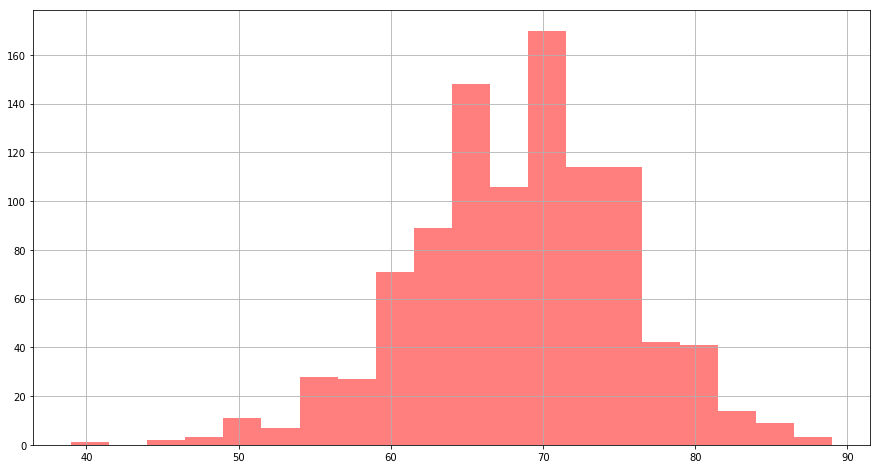

In [15]:
# See the distribution of overall rating data. 

plt.figure(figsize=(15,8))
df_subset['overall_rating'].hist(bins=20, color='red', alpha=0.5)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

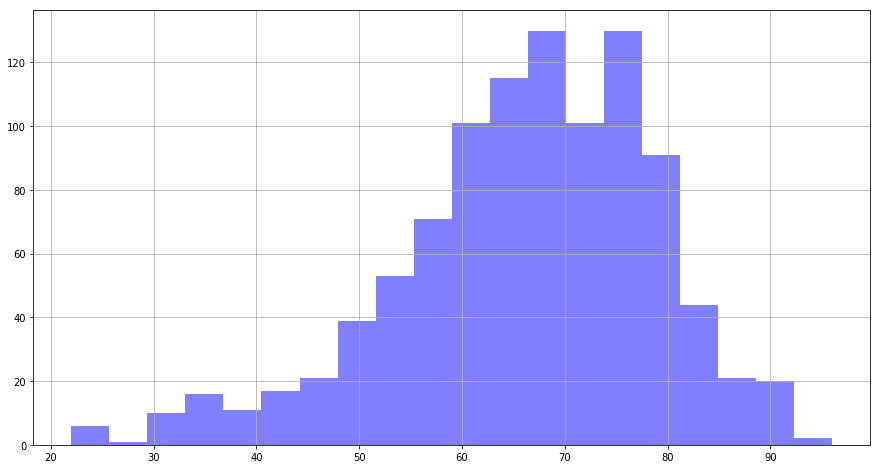

In [16]:
# See the distribution of agility data.

plt.figure(figsize=(15,8))
df_subset['agility'].hist(bins=20, color='blue', alpha=0.5)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

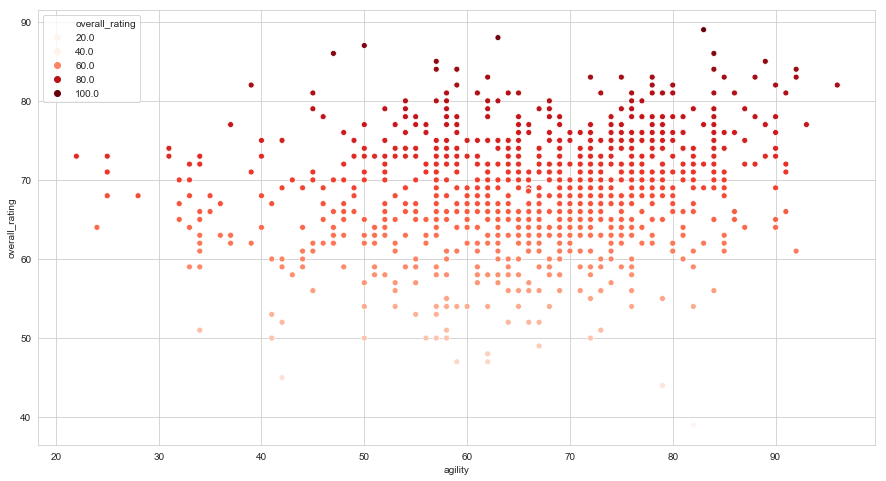

In [17]:
# See if there is a relationship between agility and the overall rating of the player.

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.scatterplot(x='agility', y='overall_rating', data=df_subset, hue='overall_rating', palette='Reds')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

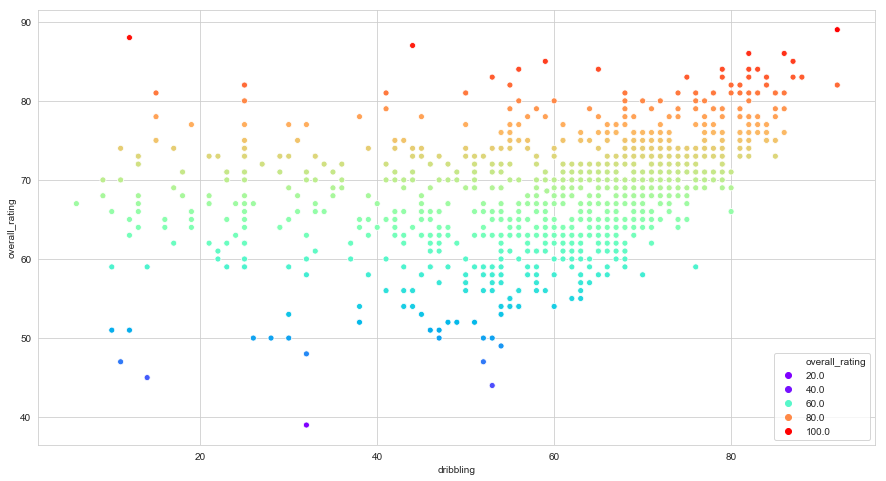

In [18]:
# See if there is a relationship between dribling and the overall rating of the player.

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.scatterplot(x='dribbling', y='overall_rating', data=df_subset, hue='overall_rating', palette='rainbow')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

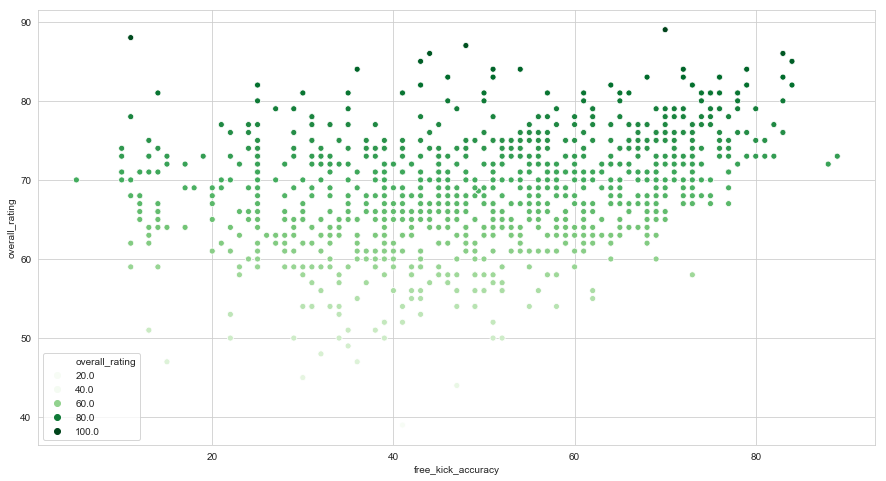

In [19]:
# See if there is a relationship between free kick accuracy and the overall rating of the player.

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.scatterplot(x='free_kick_accuracy', y='overall_rating', data=df_subset, hue='overall_rating', palette='Greens')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

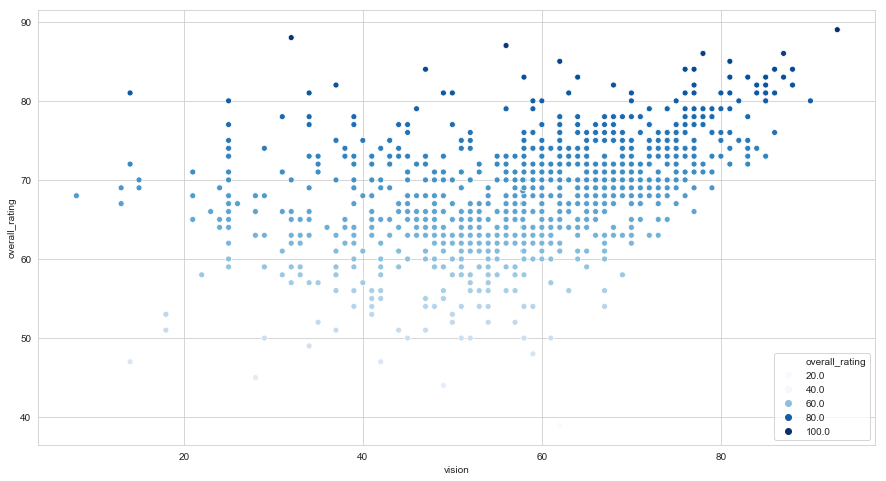

In [20]:
# See if there is a relationship between a players vision and the overall rating.

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.scatterplot(x='vision', y='overall_rating', data=df_subset, hue='overall_rating', palette='Blues')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

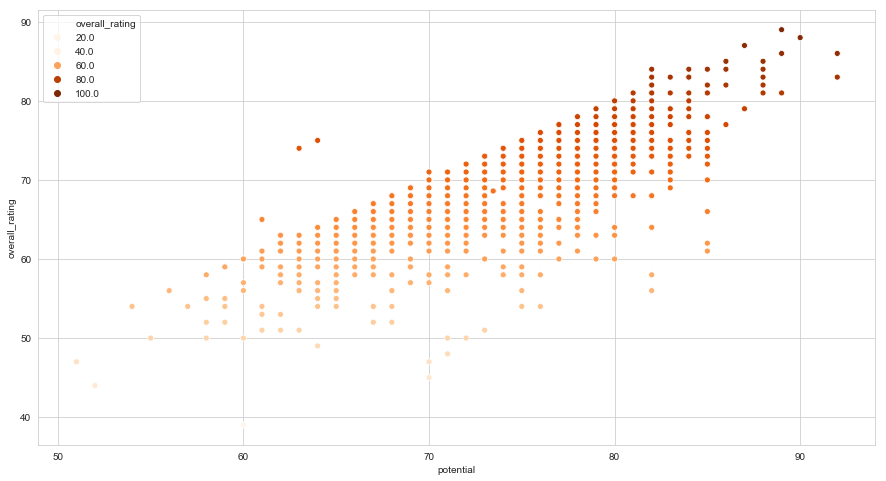

In [21]:
# See if there is a relationship between a players marking ability and the overall rating.

plt.figure(figsize=(15,8))
sns.set_style('whitegrid')
sns.scatterplot(x='potential', y='overall_rating', data=df_subset, hue='overall_rating', palette='Oranges')
plt.show

# Building Linear Regression Model

### Split the data in to Training and Test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('overall_rating', axis=1), df['overall_rating'],
                                                    test_size = 0.30, random_state = 101)

In [23]:
X_train.head()

,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
93681,75.0,62.0,44.0,53.0,62.0,55.0,65.0,58.0,68.0,54.0,...,39.0,66.0,35.0,45.0,35.0,7.0,12.0,14.0,10.0,14.0
116493,83.0,39.0,35.0,86.0,64.0,43.0,46.0,33.0,27.0,62.0,...,54.0,43.0,83.0,83.0,84.0,15.0,5.0,7.0,6.0,11.0
17520,73.0,65.0,71.0,71.0,64.0,65.0,69.0,59.0,56.0,54.0,...,56.0,72.0,33.0,46.0,39.0,6.0,10.0,11.0,10.0,10.0
97796,68.0,53.0,68.0,71.0,63.0,67.0,61.0,52.0,65.0,55.0,...,51.0,81.0,15.0,17.0,16.0,8.0,10.0,7.0,13.0,6.0
124921,67.0,57.0,49.0,63.0,67.0,59.0,66.0,58.0,56.0,64.0,...,65.0,58.0,66.0,66.0,62.0,5.0,11.0,10.0,6.0,10.0


In [24]:
y_train.head()

93681     64.0
116493    81.0
17520     71.0
97796     68.0
124921    67.0
Name: overall_rating, dtype: float64

In [25]:
# Print the shape of train and test data

print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)

X_train:  (128784, 34)
X_test:  (55194, 34)
y_train:  (128784,)
y_test:  (55194,)


### Create and Train the Linear Regression Model

In [26]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Evaluate the model by checking out it's coefficients 

In [27]:
# Find the intercept
print(lm.intercept_)

-3.7138600642612545


In [28]:
# Find the Coefficient of X train data
coeff_df = pd.DataFrame(lm.coef_,X_train.columns,columns=['Coefficient'])
print(coeff_df)

                    Coefficient
potential              0.381386
crossing               0.021691
finishing              0.012632
heading_accuracy       0.069519
short_passing          0.049780
volleys                0.002269
dribbling             -0.012380
curve                  0.010761
free_kick_accuracy     0.014515
long_passing           0.006448
ball_control           0.135916
acceleration           0.005902
sprint_speed           0.009651
agility               -0.008306
reactions              0.208145
balance                0.007479
shot_power             0.015337
jumping                0.016442
stamina               -0.005122
strength               0.061832
long_shots            -0.011895
aggression             0.020297
interceptions          0.013100
positioning           -0.010003
vision                -0.002524
penalties              0.013118
marking                0.034321
standing_tackle        0.002232
sliding_tackle        -0.029936
gk_diving              0.166042
gk_handl

### Make the Predictions

In [29]:
y_pred = lm.predict(X_test)

In [30]:
# Compare the Actual Overall Rating to the Predicted Overall Rating

ActualvsPred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [31]:
print(ActualvsPred.head(20))

        Actual  Predicted
89795     81.0  76.500393
145987    72.0  68.447011
81345     65.0  64.701619
40399     76.0  73.147422
143301    76.0  72.540214
134213    70.0  70.926820
183666    74.0  76.433557
89101     57.0  56.650473
48414     71.0  70.949247
124003    63.0  62.383194
179632    70.0  70.053771
101291    64.0  63.346655
95221     78.0  79.922389
30845     69.0  61.572655
4734      74.0  69.891753
53097     74.0  73.911948
128101    68.0  68.187802
12918     69.0  64.483406
50195     59.0  67.410854
162266    63.0  62.247938


In [32]:
# Calculate the R Squared value of the Actual Overall Rating to the Predicted Overall Rating
score = r2_score(y_test,y_pred)
print('R Sqaured Score of the Test data is: ', score)

R Sqaured Score of the Test data is:  0.8424268878510373


In [33]:
print('Mean Absolute Error (MAE) of Test data is: ',metrics.mean_absolute_error(y_test,y_pred))
print('Mean Squared Error (MSE) of Test data is: ',metrics.mean_squared_error(y_test,y_pred))
print('Root Mean Squared Error (RMSE) of Test data is: ',np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

Mean Absolute Error (MAE) of Test data is:  2.124357660885702
Mean Squared Error (MSE) of Test data is:  7.7783783388997545
Root Mean Squared Error (RMSE) of Test data is:  2.788974424210404


In [34]:
# The R2 Score of 0.8424, therefore our model can predict the overall rating of the players with
# approximately 84% accuracy based on the player attributes.

### Model Evaluation with Categorical Variables

In [35]:
conn = sqlite3.connect('database.sqlite')
df1 = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

In [36]:
df1.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date'], axis=1, inplace=True)

In [37]:
df1.head()

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [38]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 38 columns):
overall_rating         183142 non-null float64
potential              183142 non-null float64
preferred_foot         183142 non-null object
attacking_work_rate    180748 non-null object
defensive_work_rate    183142 non-null object
crossing               183142 non-null float64
finishing              183142 non-null float64
heading_accuracy       183142 non-null float64
short_passing          183142 non-null float64
volleys                181265 non-null float64
dribbling              183142 non-null float64
curve                  181265 non-null float64
free_kick_accuracy     183142 non-null float64
long_passing           183142 non-null float64
ball_control           183142 non-null float64
acceleration           183142 non-null float64
sprint_speed           183142 non-null float64
agility                181265 non-null float64
reactions              183142 non-null float64

In [39]:
df1.isnull().sum(axis=0)

overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving               836
gk_handling             836
gk_kicking          

In [40]:
pd.value_counts(df1['preferred_foot'])

right    138409
left      44733
Name: preferred_foot, dtype: int64

In [43]:
# See what other values are in the attacking work rate column aside from the null values

pd.value_counts(df1['attacking_work_rate'])

medium    125070
high       42823
low         8569
None        3639
norm         348
y            106
le           104
stoc          89
Name: attacking_work_rate, dtype: int64

In [44]:
# See what other values are in the defensive work rate column aside from the null values

pd.value_counts(df1['defensive_work_rate'])

medium    130846
high       27041
low        18432
_0          2394
o           1550
1            441
ormal        348
2            342
3            258
5            234
7            217
0            197
6            197
9            152
4            116
es           106
ean          104
tocky         89
8             78
Name: defensive_work_rate, dtype: int64

In [45]:
# Create a function to replace null values in the preferred foot column with the preferred
# foot as right since most players are right footed. 

def impute_preferred_foot (cols):
    preferred_foot = cols[0]
    
    if pd.isnull(preferred_foot):
        return 'right'
    else:
        return preferred_foot

In [46]:
# Apply the function to replace the null values in the preferred foot column

df1['preferred_foot'] = df1[['preferred_foot']].apply(impute_preferred_foot, axis=1)

In [47]:
df1.isnull().sum(axis=0)

overall_rating          836
potential               836
preferred_foot            0
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle         836
sliding_tackle         2713
gk_diving               836
gk_handling             836
gk_kicking          

In [48]:
pd.value_counts(df1['preferred_foot'])

right    139245
left      44733
Name: preferred_foot, dtype: int64

In [49]:
# Create a function to replace None, norm and null values in the attacking work rate column with 
# medium since most players are classified with medium attacking rate. Replace y, le, and stoc.

def impute_attacking_rate (cols):
    attacking_work_rate = cols[0]
    
    if pd.isnull(attacking_work_rate):
        return 'medium'
    elif attacking_work_rate == 'None' or attacking_work_rate == 'norm':
        return 'medium'
    elif attacking_work_rate == 'y' or attacking_work_rate == 'le' or attacking_work_rate == 'stoc':
        return 'low'
    
    else:
        return  attacking_work_rate

In [50]:
# Apply the function to replace the None, norm, and null values in the attacking work rate column

df1['attacking_work_rate'] = df1[['attacking_work_rate']].apply(impute_attacking_rate, axis=1)

In [51]:
pd.value_counts(df1['attacking_work_rate'])

medium    132287
high       42823
low         8868
Name: attacking_work_rate, dtype: int64

In [52]:
# Create a function to replace null and other values that is not high, medium or low in the defensive work rate column with 
# either high, medium or low.

def impute_defensive_rate (cols):
    defensive_work_rate = cols[0]
    
    if pd.isnull(defensive_work_rate):
        return 'medium'
    elif defensive_work_rate in ('_0', 'o', '0','1','2','3'):
        return 'low'
    elif defensive_work_rate in ('ormal', 'es', 'ean', 'tocky', '4','5','6'):
        return 'medium'
    elif defensive_work_rate in ('7','8','9'):
        return 'high'
    
    else:
        return  defensive_work_rate

In [53]:
# Apply the function to replace the values in the defensive work rate column

df1['defensive_work_rate'] = df1[['defensive_work_rate']].apply(impute_defensive_rate, axis=1)

In [54]:
pd.value_counts(df1['defensive_work_rate'])

medium    132876
high       27488
low        23614
Name: defensive_work_rate, dtype: int64

In [57]:
# Replace all the null values in the columns with numerical values with mean values 

df1.fillna(df.mean(), inplace=True)

In [58]:
df1.isnull().sum(axis=0)

overall_rating         0
potential              0
preferred_foot         0
attacking_work_rate    0
defensive_work_rate    0
crossing               0
finishing              0
heading_accuracy       0
short_passing          0
volleys                0
dribbling              0
curve                  0
free_kick_accuracy     0
long_passing           0
ball_control           0
acceleration           0
sprint_speed           0
agility                0
reactions              0
balance                0
shot_power             0
jumping                0
stamina                0
strength               0
long_shots             0
aggression             0
interceptions          0
positioning            0
vision                 0
penalties              0
marking                0
standing_tackle        0
sliding_tackle         0
gk_diving              0
gk_handling            0
gk_kicking             0
gk_positioning         0
gk_reflexes            0
dtype: int64

In [59]:
# We will convert the preferred foot, attacking work rate and defensive work rate columns
# to dummy variable (LabelEncoding) and drop one column (OneHotEncoding)
# This will create a new dataframe for each feature

pref_foot = pd.get_dummies(df1['preferred_foot'], drop_first=True)
attack_rate = pd.get_dummies(df1['attacking_work_rate'], drop_first=True)
def_rate = pd.get_dummies(df1['defensive_work_rate'], drop_first=True)

In [60]:
pref_foot.head()

,right
0,1
1,1
2,1
3,1
4,1


In [61]:
attack_rate.head()

,low,medium
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [62]:
def_rate.head()

,low,medium
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [64]:
# We will drop the preferred foot, attacking work rate, and defensive work rate columns from the
# original dataset since we created the dummy variable.
df1.drop(['preferred_foot', 'attacking_work_rate', 'defensive_work_rate'], axis=1, inplace=True)

In [65]:
# We will concatenate the pref_foot, attack_rate, and def_rate dummy variables to our dataset.
df1 = pd.concat([df1,pref_foot, attack_rate, def_rate],axis=1)

In [66]:
df1.head()

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,right,low,medium,low,medium
0,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,6.0,11.0,10.0,8.0,8.0,1,0,1,0,1
1,67.0,71.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,6.0,11.0,10.0,8.0,8.0,1,0,1,0,1
2,62.0,66.0,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,...,6.0,11.0,10.0,8.0,8.0,1,0,1,0,1
3,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,5.0,10.0,9.0,7.0,7.0,1,0,1,0,1
4,61.0,65.0,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,...,5.0,10.0,9.0,7.0,7.0,1,0,1,0,1


# Building Linear Regression Model

### Split the data in to Training and Test set

In [74]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df1.drop('overall_rating', axis=1), df1['overall_rating'],
                                                    test_size = 0.30, random_state = 101)

### Create and Train the Linear Regression Model

In [75]:
lm1 = LinearRegression()
lm1.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

### Evaluate the model by checking out it's coefficients 

In [76]:
# Find the intercept
print(lm1.intercept_)

-3.385317880706424


In [77]:
# Find the Coefficient of X train data
coeff_df1 = pd.DataFrame(lm1.coef_,X_train.columns,columns=['Coefficient'])
print(coeff_df1)

                    Coefficient
potential              0.379404
crossing               0.022461
finishing              0.013157
heading_accuracy       0.068397
short_passing          0.051094
volleys                0.001255
dribbling             -0.010241
curve                  0.011260
free_kick_accuracy     0.014685
long_passing           0.006015
ball_control           0.134659
acceleration           0.005330
sprint_speed           0.011517
agility               -0.008333
reactions              0.206745
balance                0.006603
shot_power             0.015242
jumping                0.016285
stamina               -0.003735
strength               0.060123
long_shots            -0.012203
aggression             0.019422
interceptions          0.012227
positioning           -0.008913
vision                -0.002528
penalties              0.012153
marking                0.033513
standing_tackle        0.002884
sliding_tackle        -0.028418
gk_diving              0.168623
gk_handl

### Make the Predictions

In [78]:
y_pred1 = lm1.predict(X_test1)

In [79]:
# Compare the Actual Overall Rating to the Predicted Overall Rating

ActualvsPred1 = pd.DataFrame({'Actual': y_test1, 'Predicted': y_pred1})

In [80]:
print(ActualvsPred1.head(20))

        Actual  Predicted
89795     81.0  76.111882
145987    72.0  68.868899
81345     65.0  64.514367
40399     76.0  74.088600
143301    76.0  72.186087
134213    70.0  71.078865
183666    74.0  77.415047
89101     57.0  56.946604
48414     71.0  70.983164
124003    63.0  62.456015
179632    70.0  70.228510
101291    64.0  63.799896
95221     78.0  79.896610
30845     69.0  61.548103
4734      74.0  69.939717
53097     74.0  73.631112
128101    68.0  68.003258
12918     69.0  65.502644
50195     59.0  68.702345
162266    63.0  62.179165


In [81]:
# Calculate the R Squared value of the Actual Overall Rating to the Predicted Overall Rating

score1 = r2_score(y_test1,y_pred1)
print('R Sqaured Score of the Test data is: ', score1)

R Sqaured Score of the Test data is:  0.8445423047381513


In [82]:
print('Mean Absolute Error (MAE) of Test data is: ',metrics.mean_absolute_error(y_test1,y_pred1))
print('Mean Squared Error (MSE) of Test data is: ',metrics.mean_squared_error(y_test1,y_pred1))
print('Root Mean Squared Error (RMSE) of Test data is: ',np.sqrt(metrics.mean_squared_error(y_test1,y_pred1)))

Mean Absolute Error (MAE) of Test data is:  2.111661475923508
Mean Squared Error (MSE) of Test data is:  7.673953715510228
Root Mean Squared Error (RMSE) of Test data is:  2.770190194826021


In [83]:
# The R2 Score of 0.8445, therefore our model can predict the overall rating of the players with
# approximately 84% accuracy based on the player attributes. The R2 score did not change significantly therefore
# the categorical columns did not impact my model. 